# Tree Based Models

In this notebook, we will model the relation between weather data and adjusted bike trips using decision tree regression model, as well as boosting algorithm based on decision trees.

## Summary of Notebook

1. Model the trend by
    1. First scale the covid data and then perform overall linear regression
    2. Perform linear regression separately over pre-covid and post-covid period. 
2. The detrending work are done in section "Overall Linear Trend" and "Piecewise Linear Trend". Plots of detrended data are available there as well.
3. We stored the result of overall linear trend into bikeshare_train_data_v1.csv, bikeshare_test_data_v1.csv and piecewise linear trend into bikeshare_train_data_v2.csv, bikeshare_test_data_v2.csv. Two columns are added. First is 'adj_num_trips' which is detrended 'num_trips'. Second is 'trend' which is our predicted trend in case we need to recover un-detrended data. 

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
# import training data
bike_train = pd.read_csv('../EDA/bikeshare_train_data.csv')

In [4]:
# import testing data
bike_test = pd.read_csv('../EDA/bikeshare_test_data.csv')

In [5]:
bike_test['adj_num_trips'] = 0

## Problem of Polynomial Trend

In [6]:
# record the coefficients of polynomial regression of trend from previous notebook
trend_reg_type = 'polynomial'
intercept = 365.77928898911864
a_1 = 1.54942756e+00
a_2 = -2.91076556e-03
a_3 = 1.30275522e-06
shift = 1318.3332525370422 
# 'shift' is the amount by which we shifted the adj_num_trips in order to make all values non-negative

In [7]:
def cal_trend(t):
    return(intercept + a_1*t + a_2*(t**2) + a_3*(t**3) + shift)

In [8]:
bike_train_c = bike_train.copy()
bike_test_c = bike_test.copy()

In [9]:
bike_train_c['time'] = np.arange(len(bike_train_c))
bike_test_c['time'] = np.arange(len(bike_test_c)) + len(bike_train_c)

In [10]:
bike_train_c['trend'] = bike_train_c['time'].apply(cal_trend)
bike_test_c['trend'] = bike_test_c['time'].apply(cal_trend)

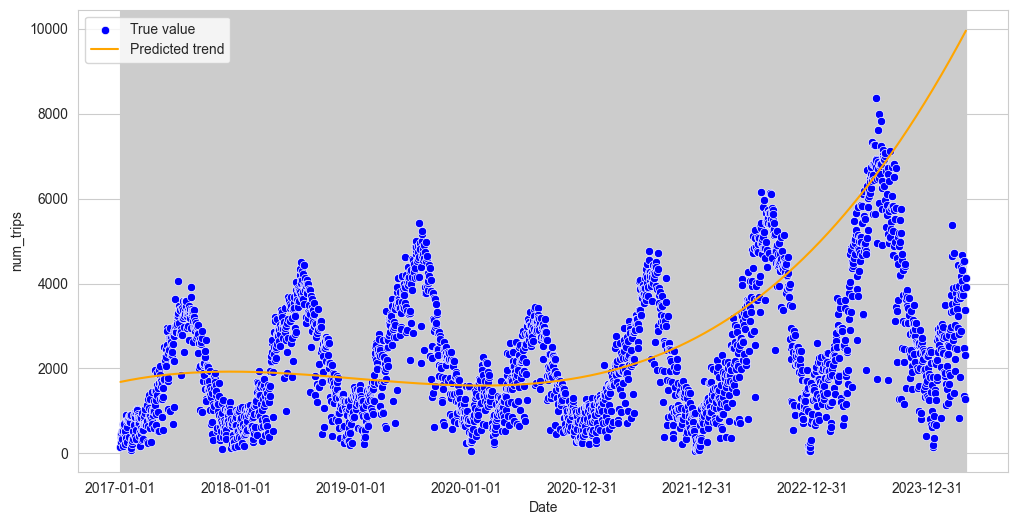

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_train_c['Date'], y=bike_train_c['num_trips'], ax=ax, color='blue', label='True value')
sns.lineplot(x=bike_train_c['Date'], y=bike_train_c['trend'], ax=ax, color='orange', label='Predicted trend')
sns.scatterplot(x=bike_test_c['Date'], y=bike_test_c['num_trips'], ax=ax, color='blue')
sns.lineplot(x=bike_test_c['Date'], y=bike_test_c['trend'], ax=ax, color='orange')

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 365th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
            
plt.legend()
plt.show()

In [12]:
del(bike_train_c)
del(bike_test_c)

## Preparation Work : Scale the Covid Data before Overall Linear Regression (Skip)

In [13]:
def get_weather_month(s):
    return(int(s.split('/')[0]))

In [14]:
bike_total = pd.concat([bike_train,bike_test],ignore_index=True)

In [15]:
bike_total['adj_num_trips'] = bike_total['num_trips'].astype('float')

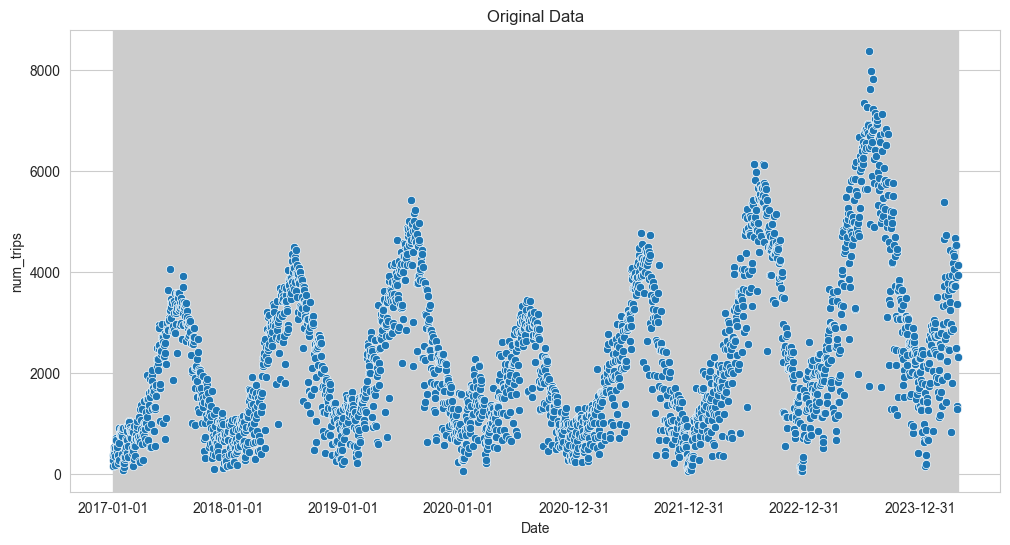

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_total['Date'], y=bike_total['num_trips'], ax=ax)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 365th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.title('Original Data')       
plt.show()

In [17]:
# check which month was the start of the covid decrease
def get_ym(date):
    return(date[0:7])
bike_total['year-month'] = bike_total['Date'].apply(get_ym)

In [18]:
max_2019 = bike_total.iloc[365*2:365*3]['num_trips'].max()
max_2020 = bike_total.iloc[365*3+60:365*4]['num_trips'].max()
max_2021 = bike_total.iloc[365*4:365*5]['num_trips'].max()

In [19]:
bike_total.loc[365*3+60:365*4,'adj_num_trips'] *= max_2019/max_2020

In [20]:
bike_total.loc[365*4:365*5,'adj_num_trips'] *= max_2019/max_2021

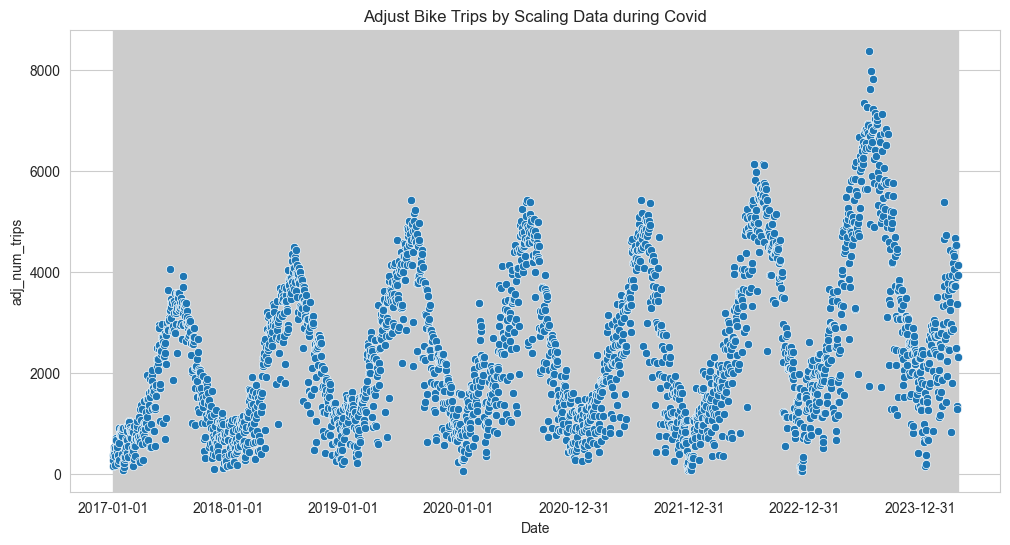

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_total['Date'], y=bike_total['adj_num_trips'], ax=ax)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 365th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        

plt.title('Adjust Bike Trips by Scaling Data during Covid')        
plt.show()

In [22]:
bike_total['station_count'] = np.nan

In [23]:
station_count = []

In [24]:
# import 2017 data
df = pd.read_csv('../preprocessing/bike data/raw data/All of 2017.csv')
df['Month'] = df['Departure'].apply(get_weather_month)
station_count.extend(df.groupby('Month')['Departure station'].nunique().values)
del(df)

In [25]:
# import 2018-2020 data
for year in range(2018,2024):
    for month in ['January','February','March','April','May','June','July','August','September','October','November','December']:
        filepath = '../preprocessing/bike data/raw data/' + month + ' ' + str(year) + '.csv'
        df = pd.read_csv(filepath)
        station_count.append(df['Departure station'].nunique())
        del(df)

/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_74249/3884814474.py:5: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_74249/3884814474.py:5: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_74249/3884814474.py:5: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_74249/3884814474.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_74249/3884814474.py:5: DtypeWarning: Columns (2) have mixed types. 

In [26]:
for month in ['January','February','March','April']:
    filepath = '../preprocessing/bike data/raw data/' + month + ' ' + '2024' + '.csv'
    df = pd.read_csv(filepath)
    station_count.append(df['Departure station'].nunique())
    del(df)

In [27]:
bike_total.loc[0,'station_count'] = station_count[0]
for i in bike_total.index:
    if i>0:
        bike_total.loc[i,'station_count'] = max(bike_total.loc[i-1,'station_count'], station_count[min(i//30,len(station_count)-1)])

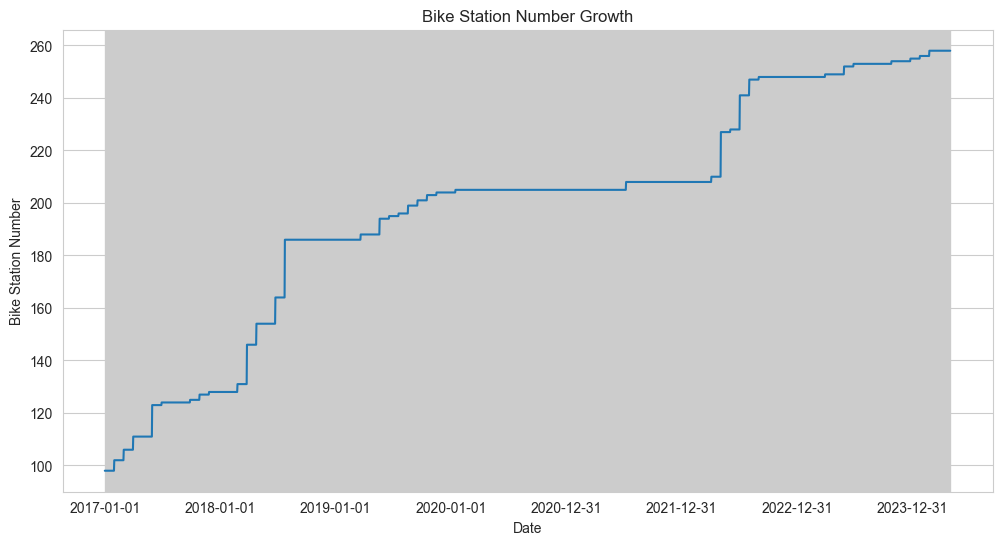

In [28]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(12)

sns.lineplot(data=bike_total, x='Date', y='station_count', ax=ax)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Bike Station Number', fontsize=10)
plt.title('Bike Station Number Growth',fontsize=12)

plt.show()


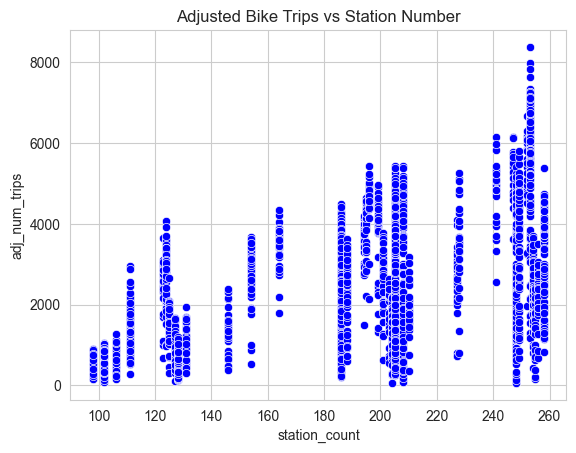

In [29]:
sns.scatterplot(x=bike_total['station_count'], y=bike_total['adj_num_trips'],color='blue')
plt.title('Adjusted Bike Trips vs Station Number')
plt.show()

In [30]:
# correlation
bike_total[['station_count','adj_num_trips']].corr()

,station_count,adj_num_trips
station_count,1.000000,0.391348
adj_num_trips,0.391348,1.000000


In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
reg = LinearRegression()
reg.fit(bike_total.loc[bike_train.index,['station_count']],bike_total.loc[bike_train.index,'adj_num_trips'])
pred = reg.predict(bike_total[['station_count']])

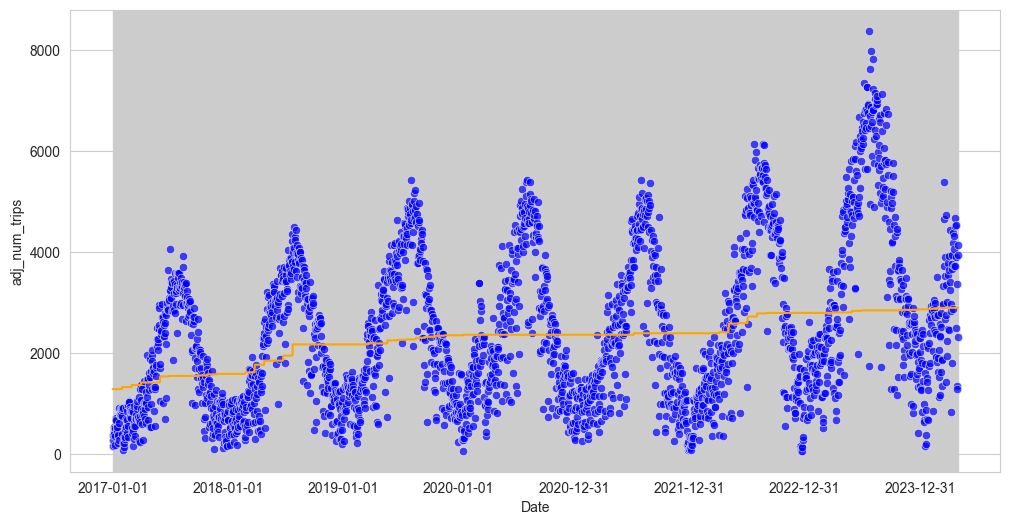

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_total['Date'], y=bike_total['adj_num_trips'], color='blue', alpha=0.7, ax=ax)
sns.lineplot(x=bike_total['Date'], y=pred, color='orange', ax=ax)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 365th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.show()

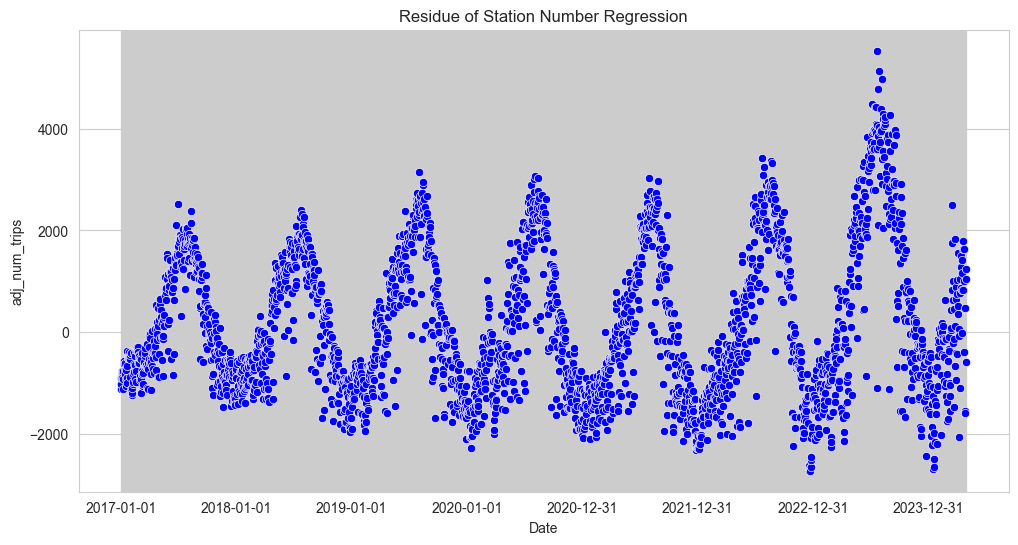

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_total['Date'], y=bike_total['adj_num_trips']-pred, color='blue', ax=ax)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 365th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.title('Residue of Station Number Regression')
        
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
# rmse
train_max_index = bike_train.index.max()
print('The rmse over the training data is', np.sqrt(mean_squared_error(bike_total.loc[:train_max_index,'adj_num_trips'],pred[:train_max_index+1])))
print('The rmse over the testing data is', np.sqrt(mean_squared_error(bike_total.loc[train_max_index+1:,'adj_num_trips'],pred[train_max_index+1:])))

The rmse over the training data is 1297.5408329490324
The rmse over the testing data is 2120.885671774602


In [37]:
# baseline trend model
aver = bike_total.loc[:train_max_index,'adj_num_trips'].mean()
print('The baseline rmse over the training data is', np.sqrt(mean_squared_error(bike_total.loc[:train_max_index,'adj_num_trips'],aver*np.ones(len(bike_train)))))
print('The baseline rmse over the testing data is', np.sqrt(mean_squared_error(bike_total.loc[train_max_index+1:,'adj_num_trips'],aver*np.ones(len(bike_test)))))

The baseline rmse over the training data is 1359.7179047466586
The baseline rmse over the testing data is 2482.700236553898


In [38]:
# overall linear model
reg = LinearRegression()
reg.fit(np.arange(len(bike_train)).reshape(-1,1),bike_total.loc[bike_train.index,'adj_num_trips'])
ol_pred_train = reg.predict(np.arange(len(bike_train)).reshape(-1,1))
ol_pred_test = reg.predict((np.arange(len(bike_test))+len(bike_train)).reshape(-1,1))
print('The overall linear model rmse over the training data is', np.sqrt(mean_squared_error(bike_total.loc[:train_max_index,'adj_num_trips'],ol_pred_train)))
print('The overall linear model rmse over the testing data is', np.sqrt(mean_squared_error(bike_total.loc[train_max_index+1:,'adj_num_trips'],ol_pred_test)))

The overall linear model rmse over the training data is 1328.765444288767
The overall linear model rmse over the testing data is 2171.720682950166


1. slightly more accurate
2. makes more sense, if mobi will not invest in more bikes/stations, the bike trips should reach some threshold

## Overall Linear Trend

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
reg = LinearRegression()

In [41]:
reg.fit(np.arange(len(bike_train)).reshape(-1,1), bike_total.loc[bike_train.index]['adj_num_trips'])

LinearRegression()

In [42]:
bike_total['l_trend'] = reg.predict(np.arange(len(bike_total)).reshape(-1,1))

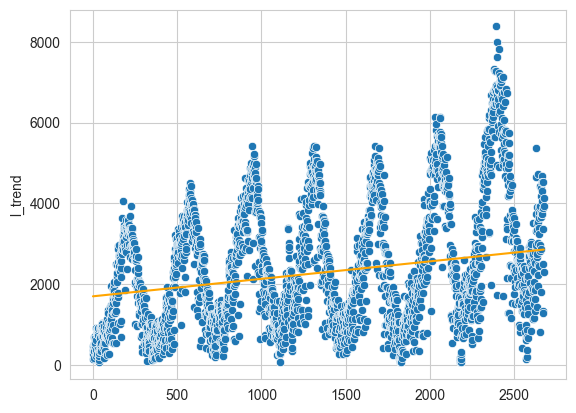

In [43]:
sns.lineplot(x=np.arange(len(bike_total)), y=bike_total['l_trend'], color='orange')
sns.scatterplot(x=np.arange(len(bike_total)), y=bike_total['adj_num_trips'])
plt.show()

In [44]:
bike_test['adj_num_trips'] = np.nan
bike_test['trend'] = np.nan

In [45]:
bike_total.iloc[len(bike_train):]['adj_num_trips'] - bike_total.iloc[len(bike_train):]['l_trend']

2311     622.465708
2312    2128.033302
2313    2086.600895
2314    1662.168489
2315   -1131.263917
           ...     
2672     510.367044
2673   -1566.065362
2674    -544.497768
2675    1071.069826
2676    1269.637419
Length: 366, dtype: float64

In [46]:
# write to csv
bike_train['adj_num_trips'] = bike_total.iloc[:len(bike_train)]['adj_num_trips'] - bike_total.iloc[:len(bike_train)]['l_trend']
bike_train['trend'] = bike_total.iloc[:len(bike_train)]['l_trend']
bike_test['adj_num_trips'] = (bike_total.iloc[len(bike_train):]['adj_num_trips'] - bike_total.iloc[len(bike_train):]['l_trend']).values
bike_test['trend'] = bike_total.iloc[len(bike_train):]['l_trend'].values

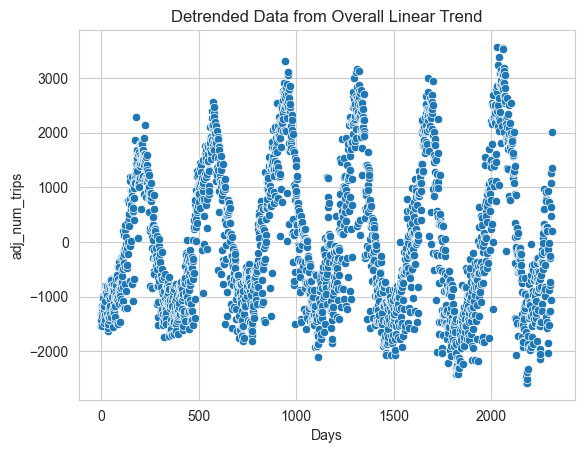

In [47]:
# check plot to make sure there is not mistake
sns.scatterplot(x=np.arange(len(bike_train)), y=bike_train['adj_num_trips'])
plt.title('Detrended Data from Overall Linear Trend')
plt.xlabel('Days')
plt.show()

In [48]:
bike_train.to_csv('bikeshare_train_data_v1.csv')
bike_test.to_csv('bikeshare_test_data_v1.csv')

## Piecewise Linear Regression

In [49]:
# we will split the time period into two period, pre_covid and post_covid(including covid). 
# The index set ind_1 and ind_2 correspond to data in these two periods respectively

In [63]:
bike_train_p = pd.read_csv('bikeshare_train_data.csv')
bike_test_p = pd.read_csv('bikeshare_test_data.csv')

In [104]:
# covid decrease starts at around March 2020
ind_1 = bike_train_p.iloc[:365*3+80].index 
# include only entire periods of the wave to avoid bringing the influence of seasonality into linear trend
# this is from the start of March 2020 to the end of February 2023
ind_2 = bike_train_p.iloc[365*3+80:365*6+80].index 

In [106]:
bike_train_p['trend'] = np.nan
bike_train_p['adj_num_trips'] = np.nan
bike_test_p['trend'] = np.nan
bike_test_p['adj_num_trips'] = np.nan

In [107]:
preg_1 = LinearRegression()
preg_2 = LinearRegression()
preg_1.fit(np.arange(len(ind_1)).reshape(-1,1),bike_train_p.loc[ind_1,'num_trips'])
preg_2.fit((np.arange(len(ind_2))+len(ind_1)).reshape(-1,1),bike_train_p.loc[ind_2,'num_trips'])

LinearRegression()

In [108]:
ind_3 = bike_train_p.iloc[365*3+80:].index 

In [109]:
bike_train_p.loc[ind_1, 'adj_num_trips'] = bike_train_p.loc[ind_1]['num_trips'] - preg_1.predict(np.arange(len(ind_1)).reshape(-1,1))
bike_train_p.loc[ind_3, 'adj_num_trips'] = bike_train_p.loc[ind_3]['num_trips'] - preg_2.predict((np.arange(len(bike_train)-len(ind_1))+len(ind_1)).reshape(-1,1))
bike_train_p.loc[ind_1, 'trend'] = preg_1.predict(np.arange(len(ind_1)).reshape(-1,1))
bike_train_p.loc[ind_3, 'trend'] = preg_2.predict((np.arange(len(ind_3))+len(ind_1)).reshape(-1,1))

In [110]:
bike_test_p['adj_num_trips'] = bike_test_p['num_trips'] - preg_2.predict((np.arange(len(bike_test_p))+len(bike_train_p)).reshape(-1,1))
bike_test_p['trend'] = preg_2.predict((np.arange(len(bike_test_p))+len(bike_train_p)).reshape(-1,1))

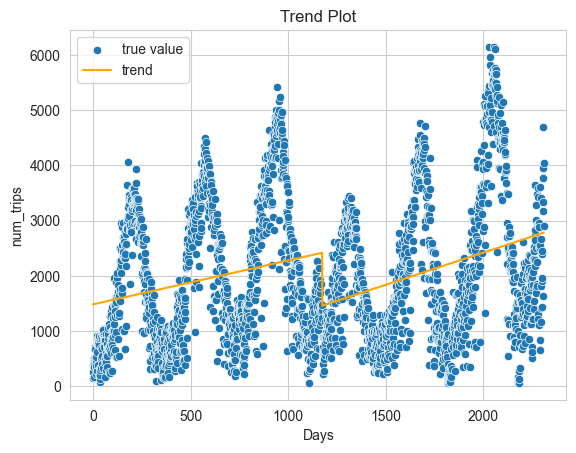

In [111]:
sns.scatterplot(x=np.arange(len(bike_train_p)), y=bike_train_p['num_trips'], label='true value')
sns.lineplot(x=np.arange(len(bike_train_p)), y=bike_train_p['trend'], label='trend', color='orange')
# sns.scatterplot(x=np.arange(len(bike_test_p))+len(bike_train_p), y=bike_test['adj_num_trips'], label='test set')
plt.title('Trend Plot')
plt.xlabel('Days')
plt.legend()
plt.show()

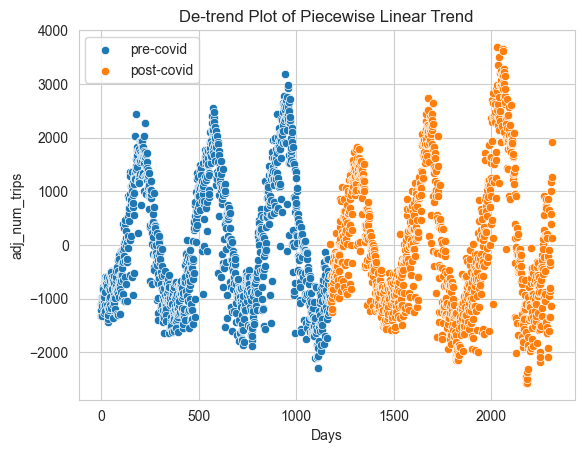

In [112]:
sns.scatterplot(x=np.arange(len(ind_1)), y=bike_train_p.loc[ind_1]['adj_num_trips'], label='pre-covid')
sns.scatterplot(x=np.arange(len(ind_3))+len(ind_1), y=bike_train_p.loc[ind_3]['adj_num_trips'], label='post-covid')
# sns.scatterplot(x=np.arange(len(bike_test_p))+len(bike_train_p), y=bike_test['adj_num_trips'], label='test set')
plt.title('De-trend Plot of Piecewise Linear Trend')
plt.xlabel('Days')
plt.legend()
plt.show()

In [113]:
# write to csv
bike_train_p.to_csv('bikeshare_train_data_v2.csv')
bike_test_p.to_csv('bikeshare_test_data_v2.csv')

## Decision Tree Regressor

In [62]:
bike_total['residue'] = bike_total['adj_num_trips'] - bike_total['l_trend'] # change bike_total['l_trend'] to pred if wanting to use station number trend model
bike_total['interaction_1'] = bike_total['max_temp'] * bike_total['l_trend']
bike_total['interaction_2'] = bike_total['total_precip'] * bike_total['l_trend']

In [63]:
features = ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2']

In [64]:
# define powerset function to return all subset of a list

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [65]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
MAX_DEPTH = 10

In [67]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=16, shuffle=True)

In [68]:
mses_train = np.zeros((5,2**len(features)-1,MAX_DEPTH))
mses_val = np.zeros((5,2**len(features)-1,MAX_DEPTH))
# the first component refers to validation number, the second component refers to the feature used, 
# the third refers to the max_depth of the tree

In [69]:
cv_count = 0

for train_index, test_index in kfold.split(bike_total.loc[bike_train.index]):
    feature_count = 0
    cv_train = bike_total.iloc[train_index]
    cv_val = bike_total.iloc[test_index]
    for feature in powerset(features):
        print(f'Feature count is {feature_count}')
        feature = list(feature)
        if len(feature) > 0:
            for max_depth in range(1,MAX_DEPTH+1):
                print(f'Fitting tree model with features {feature} and max depth {max_depth}')
                tree = DecisionTreeRegressor(max_depth = max_depth)
                tree.fit(cv_train[feature],cv_train['residue'])
        
                # predict
                pred_train = tree.predict(cv_train[feature])
                pred_val = tree.predict(cv_val[feature])
                
                # compute mse and store
                mse_train = np.sqrt(mean_squared_error(cv_train['residue'], pred_train))
                mse_val = np.sqrt(mean_squared_error(cv_val['residue'], pred_val))
                mses_train[cv_count,feature_count,max_depth-1] = mse_train
                mses_val[cv_count,feature_count,max_depth-1] = mse_val
                
                # plot the in-sample and out-of-sample prediction with true values
#                 fig, ax = plt.subplots(1,2,figsize = (12,5))
#                 sns.scatterplot(x=bike_train['time'], y=bike_train['adj_num_trips'], ax=ax[0], color='blue', alpha=0.5)
#                 sns.scatterplot(x=bike_train['time'], y=pred_train, ax=ax[0], color='orange')
            
#                 sns.scatterplot(x=bike_test['time'], y=bike_test['adj_num_trips'], ax=ax[1], color='blue', alpha=0.5)
#                 sns.scatterplot(x=bike_test['time'], y=pred_test, ax=ax[1], color='orange') 
            
#                 plt.show()
            
                # plot the residue plot
            
#                 if len(feature) == 1:
                
#                     fig, ax = plt.subplots(1,2,figsize = (12,5))
#                     sns.scatterplot(x=bike_train[feature[0]], y=bike_train['adj_num_trips'] - pred_train, ax=ax[0], color='green')
#                     sns.scatterplot(x=bike_test[feature[0]], y=bike_test['adj_num_trips'] - pred_test, ax=ax[1], color='green')
#                     ax[0].set_title(f'Residue plot of adj_num_trips against {feature[0]} in training data')
#                     ax[1].set_title(f'Residue plot of adj_num_trips against {feature[0]} in testing data')
                
#                     plt.show()
            feature_count += 1
    cv_count += 1

Feature count is 0
Feature count is 0
Fitting tree model with features ['max_temp'] and max depth 1
Fitting tree model with features ['max_temp'] and max depth 2
Fitting tree model with features ['max_temp'] and max depth 3
Fitting tree model with features ['max_temp'] and max depth 4
Fitting tree model with features ['max_temp'] and max depth 5
Fitting tree model with features ['max_temp'] and max depth 6
Fitting tree model with features ['max_temp'] and max depth 7
Fitting tree model with features ['max_temp'] and max depth 8
Fitting tree model with features ['max_temp'] and max depth 9
Fitting tree model with features ['max_temp'] and max depth 10
Feature count is 1
Fitting tree model with features ['total_precip'] and max depth 1
Fitting tree model with features ['total_precip'] and max depth 2
Fitting tree model with features ['total_precip'] and max depth 3
Fitting tree model with features ['total_precip'] and max depth 4
Fitting tree model with features ['total_precip'] and max 

Fitting tree model with features ['total_precip', 'max_gust'] and max depth 8
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 9
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 10
Feature count is 12
Fitting tree model with features ['total_precip', 'day_length'] and max depth 1
Fitting tree model with features ['total_precip', 'day_length'] and max depth 2
Fitting tree model with features ['total_precip', 'day_length'] and max depth 3
Fitting tree model with features ['total_precip', 'day_length'] and max depth 4
Fitting tree model with features ['total_precip', 'day_length'] and max depth 5
Fitting tree model with features ['total_precip', 'day_length'] and max depth 6
Fitting tree model with features ['total_precip', 'day_length'] and max depth 7
Fitting tree model with features ['total_precip', 'day_length'] and max depth 8
Fitting tree model with features ['total_precip', 'day_length'] and max depth 9
Fitting tree model with f

Feature count is 22
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 10
Feature count is 23
Fitting tree model with features ['max_

Fitting tree model with features ['max_temp', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 31
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 1
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 2
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 3
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 4
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 5
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 6
Fitting tree model with features ['total_precip', 'max_gust', 'day_length'] and max depth 7
Fitting tree model with features ['total_precip

Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 40
Fitting tree model with features ['day_length', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['day_length', 'interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['day_length', 'interaction_1', 'interaction_2'] and max depth 3
Fitting tree model with features ['day_length', 'interaction_1', 'interaction_2'] and max depth 4
Fitting tree model with features ['day_length', 'interaction_1', 'interaction_2'] and max depth 5
Fitting t

Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 4
Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 5
Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 6
Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 7
Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 55
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_gust', 'day_length', 'interactio

Fitting tree model with features ['max_temp', 'day_length'] and max depth 6
Fitting tree model with features ['max_temp', 'day_length'] and max depth 7
Fitting tree model with features ['max_temp', 'day_length'] and max depth 8
Fitting tree model with features ['max_temp', 'day_length'] and max depth 9
Fitting tree model with features ['max_temp', 'day_length'] and max depth 10
Feature count is 9
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 1
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 2
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 3
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 4
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 5
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 6
Fitting tree model with features ['max_temp', 'interaction_1'] and max depth 7
Fitting tree model with features ['max_temp', '

Fitting tree model with features ['day_length', 'interaction_2'] and max depth 2
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 3
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 4
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 5
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 6
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 7
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 8
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 9
Fitting tree model with features ['day_length', 'interaction_2'] and max depth 10
Feature count is 20
Fitting tree model with features ['interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['interaction_1', 'interaction_2'] and max depth 

Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 4
Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 5
Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 6
Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 7
Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 8
Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 9
Fitting tree model with features ['max_temp', 'day_length', 'interaction_1'] and max depth 10
Feature count is 29
Fitting tree model with features ['max_temp', 'day_length', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'day_length', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'day_length', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_temp', 'da

Feature count is 37
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 1
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 2
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 3
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 4
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 5
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 6
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 7
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 8
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 9
Fitting tree model with features ['max_gust', 'day_length', 'interaction_1'] and max depth 10
Feature count is 38
Fitting tree model with featu

Feature count is 45
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_2'] and max depth 9

Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 60
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1', 'interaction_2']

Fitting tree model with features ['interaction_2'] and max depth 9
Fitting tree model with features ['interaction_2'] and max depth 10
Feature count is 6
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 10
Feature count is 7
Fitting tree model with features ['max_temp', 

Fitting tree model with features ['max_gust', 'interaction_1'] and max depth 8
Fitting tree model with features ['max_gust', 'interaction_1'] and max depth 9
Fitting tree model with features ['max_gust', 'interaction_1'] and max depth 10
Feature count is 17
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 4
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_gust', 'interaction_2'] and max depth 9
Fitting tree model with feature

Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 3
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 4
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 5
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 6
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 7
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 8
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 9
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1'] and max depth 10
Feature count is 27
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'max_gust', 'interactio

Fitting tree model with features ['total_precip', 'day_length', 'interaction_1'] and max depth 10
Feature count is 35
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 1
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 2
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 3
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 4
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 5
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 6
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 7
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 8
Fitting tree model with features ['total_precip', 'day_length', 'interaction_2'] and max depth 9
Fitting t

Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_2'] and max depth 10
Feature count is 44
Fitting tree mod

Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_2'] and max depth 10
Feature count is 58
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 4

Fitting tree model with features ['total_precip', 'interaction_1'] and max depth 7
Fitting tree model with features ['total_precip', 'interaction_1'] and max depth 8
Fitting tree model with features ['total_precip', 'interaction_1'] and max depth 9
Fitting tree model with features ['total_precip', 'interaction_1'] and max depth 10
Feature count is 14
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 1
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 2
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 3
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 4
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 5
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 6
Fitting tree model with features ['total_precip', 'interaction_2'] and max depth 7
Fitting tree model with features ['total_precip', 'interaction_2']

Fitting tree model with features ['max_temp', 'total_precip', 'interaction_1'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_1'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_1'] and max depth 10
Feature count is 24
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_2'] and max depth 7
Fitting tree model with featu

Fitting tree model with features ['total_precip', 'max_gust', 'interaction_1'] and max depth 5
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_1'] and max depth 6
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_1'] and max depth 7
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_1'] and max depth 8
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_1'] and max depth 9
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_1'] and max depth 10
Feature count is 33
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_2'] and max depth 1
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_2'] and max depth 2
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_2'] and max depth 3
Fitting tree model with features ['total_precip', 'max_gust', 'interaction_2'] and max depth 4
Fitting tree model with featu

Feature count is 41
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length'] and max depth 9
Fitting tree model with features ['max_temp'

Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_2'] and max depth 10
Feature count is 49
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 4
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_temp', 'max_gust', 'interaction_1', 'interaction_2'] and max depth 6
Fitting tree mod

Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 0
Feature count is 0
Fitting tree model with features ['max_temp'] and max depth 1
Fitting tree model with features ['max_temp'] and max depth 2
Fitting t

Fitting tree model with features ['max_temp', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'interaction_2'] and max depth 10
Feature count is 11
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 1
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 2
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 3
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 4
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 5
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 6
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 7
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 8
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 9
Fitting tree model with features ['total_precip', 'max_gust'] and max depth 10
Feature count is 12
Fitting tree model w

Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 10
Feature count is 22
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'day_le

Fitting tree model with features ['max_gust', 'day_length', 'interaction_2'] and max depth 10
Feature count is 39
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 3
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 4
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 5
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 6
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 7
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_gust', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model wit

Fitting tree model with features ['max_temp', 'total_precip', 'interaction_1', 'interaction_2'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 47
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1'] and max depth 1
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1'] and max depth 2
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1'] and max depth 3
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1'] and max depth 4
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1'] and max depth 5
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1'] and max depth 6
Fitting tree 

Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 9
Fitting tree model with features ['max_temp', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 10
Feature count is 61
Fitting tree model with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 1
Fitting tree model with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 2
Fitting tree model with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 3
Fitting tree model with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 4
Fitting tree model with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2'] and max depth 5
Fitting tree model with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction

In [70]:
# compute the average of rmses
avg_rmses_train = np.zeros((2**len(features)-1,MAX_DEPTH))
avg_rmses_val = np.zeros((2**len(features)-1,MAX_DEPTH))
for i in range(2**len(features)-1):
    for j in range(MAX_DEPTH):
        avg_rmses_train[i,j] = mses_train[:,i,j].mean()
        avg_rmses_val[i,j] = mses_val[:,i,j].mean()

In [71]:
ind_train = np.unravel_index(np.argmin(avg_rmses_train, axis=None), avg_rmses_train.shape)
ind_val = np.unravel_index(np.argmin(avg_rmses_val, axis=None), avg_rmses_val.shape)

In [72]:
print(ind_train)
print(ind_val)

(62, 9)
(50, 6)


In [73]:
print('The minimum of the average validation rmse among all the decision tree regressor is', avg_rmses_val[ind_val])
print('The average training rmse of the tree above is', avg_rmses_train[ind_val])

The minimum of the average validation rmse among all the decision tree regressor is 507.28947920534966
The average training rmse of the tree above is 382.31626355062


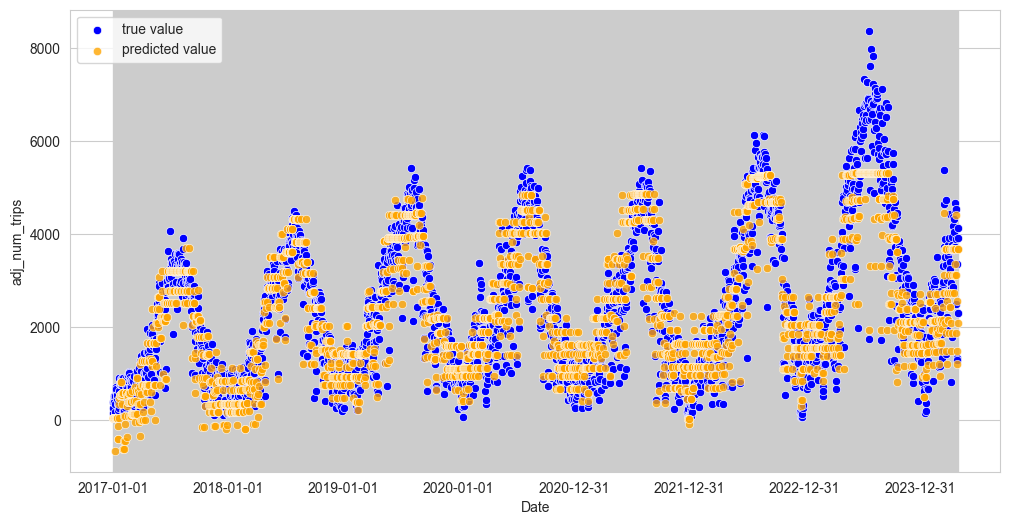

In [74]:
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(bike_total.loc[bike_train.index][['max_temp', 'interaction_1', 'interaction_2']],bike_total.loc[bike_train.index]['residue'])
tree_pred = tree.predict(bike_total[['max_temp', 'interaction_1', 'interaction_2']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_total['Date'], y=bike_total['adj_num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_total['Date'], y=pred + tree_pred, color='orange', ax=ax, alpha=0.8, label='predicted value')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.legend()
plt.show()

In [75]:
test_index = bike_total.iloc[len(bike_train):].index

In [76]:
pred_test = bike_total.loc[test_index]['l_trend'] + tree.predict(bike_total.loc[test_index][['max_temp', 'interaction_1', 'interaction_2']])

## Simple Linear Regression

In [74]:
mses_l_train = np.zeros((5,2**len(features)-1))
mses_l_val = np.zeros((5,2**len(features)-1))

In [75]:
cv_count = 0

for train_index, test_index in kfold.split(bike_total.loc[bike_train.index]):
    feature_count = 0
    cv_train = bike_total.iloc[train_index]
    cv_val = bike_total.iloc[test_index]
    for feature in powerset(features):
        print(f'Feature count is {feature_count}')
        feature = list(feature)
        if len(feature) > 0:
            print(f'Fitting linear regressor with features {feature}')
            reg_val = LinearRegression()
            reg_val.fit(cv_train[feature],cv_train['residue'])
        
            # predict
            pred_train = reg_val.predict(cv_train[feature])
            pred_val = reg_val.predict(cv_val[feature])
                
            # compute mse and store
            mse_l_train = np.sqrt(mean_squared_error(cv_train['residue'], pred_train))
            mse_l_val = np.sqrt(mean_squared_error(cv_val['residue'], pred_val))
            mses_l_train[cv_count,feature_count] = mse_l_train
            mses_l_val[cv_count,feature_count] = mse_l_val

            feature_count += 1
    cv_count += 1

Feature count is 0
Feature count is 0
Fitting linear regressor with features ['max_temp']
Feature count is 1
Fitting linear regressor with features ['total_precip']
Feature count is 2
Fitting linear regressor with features ['max_gust']
Feature count is 3
Fitting linear regressor with features ['day_length']
Feature count is 4
Fitting linear regressor with features ['interaction_1']
Feature count is 5
Fitting linear regressor with features ['interaction_2']
Feature count is 6
Fitting linear regressor with features ['max_temp', 'total_precip']
Feature count is 7
Fitting linear regressor with features ['max_temp', 'max_gust']
Feature count is 8
Fitting linear regressor with features ['max_temp', 'day_length']
Feature count is 9
Fitting linear regressor with features ['max_temp', 'interaction_1']
Feature count is 10
Fitting linear regressor with features ['max_temp', 'interaction_2']
Feature count is 11
Fitting linear regressor with features ['total_precip', 'max_gust']
Feature count is 12

Feature count is 34
Fitting linear regressor with features ['total_precip', 'day_length', 'interaction_1']
Feature count is 35
Fitting linear regressor with features ['total_precip', 'day_length', 'interaction_2']
Feature count is 36
Fitting linear regressor with features ['total_precip', 'interaction_1', 'interaction_2']
Feature count is 37
Fitting linear regressor with features ['max_gust', 'day_length', 'interaction_1']
Feature count is 38
Fitting linear regressor with features ['max_gust', 'day_length', 'interaction_2']
Feature count is 39
Fitting linear regressor with features ['max_gust', 'interaction_1', 'interaction_2']
Feature count is 40
Fitting linear regressor with features ['day_length', 'interaction_1', 'interaction_2']
Feature count is 41
Fitting linear regressor with features ['max_temp', 'total_precip', 'max_gust', 'day_length']
Feature count is 42
Fitting linear regressor with features ['max_temp', 'total_precip', 'max_gust', 'interaction_1']
Feature count is 43
Fitti

Feature count is 61
Fitting linear regressor with features ['total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2']
Feature count is 62
Fitting linear regressor with features ['max_temp', 'total_precip', 'max_gust', 'day_length', 'interaction_1', 'interaction_2']
Feature count is 0
Feature count is 0
Fitting linear regressor with features ['max_temp']
Feature count is 1
Fitting linear regressor with features ['total_precip']
Feature count is 2
Fitting linear regressor with features ['max_gust']
Feature count is 3
Fitting linear regressor with features ['day_length']
Feature count is 4
Fitting linear regressor with features ['interaction_1']
Feature count is 5
Fitting linear regressor with features ['interaction_2']
Feature count is 6
Fitting linear regressor with features ['max_temp', 'total_precip']
Feature count is 7
Fitting linear regressor with features ['max_temp', 'max_gust']
Feature count is 8
Fitting linear regressor with features ['max_temp', 'day_length']


In [76]:
# compute the average of rmses
avg_rmses_l_train = np.zeros(2**len(features)-1)
avg_rmses_l_val = np.zeros(2**len(features)-1)
for i in range(2**len(features)-1):
    avg_rmses_l_train[i] = mses_train[:,i].mean()
    avg_rmses_l_val[i] = mses_val[:,i].mean()

In [77]:
ind_l_train = np.unravel_index(np.argmin(avg_rmses_l_train, axis=None), avg_rmses_l_train.shape)
ind_l_val = np.unravel_index(np.argmin(avg_rmses_l_val, axis=None), avg_rmses_l_val.shape)

In [78]:
print(ind_l_train)
print(ind_l_val)

(62,)
(50,)


In [79]:
print('The minimum of the average validation rmse among all the linear regressor is', avg_rmses_l_val[ind_val[0]])
print('The average training rmse of the linear regressor above is', avg_rmses_l_train[ind_val[0]])

The minimum of the average validation rmse among all the linear regressor is 575.8381265037514
The average training rmse of the linear regressor above is 464.06120839684445


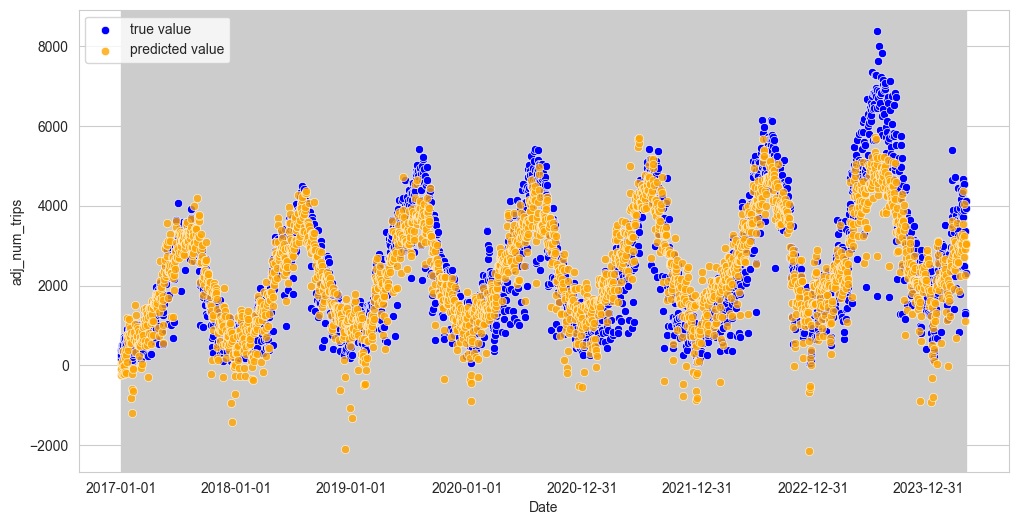

In [80]:
lreg = LinearRegression()
lreg.fit(bike_total.loc[bike_train.index][['max_temp', 'day_length', 'interaction_1', 'interaction_2']],bike_total.loc[bike_train.index]['residue'])
lreg_pred = lreg.predict(bike_total[['max_temp', 'day_length', 'interaction_1', 'interaction_2']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_total['Date'], y=bike_total['adj_num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_total['Date'], y=bike_total['l_trend'] + lreg_pred, color='orange', ax=ax, alpha=0.8, label='predicted value')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 365 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.legend()
plt.show()

In [81]:
pred_l_test = bike_total.loc[test_index]['l_trend'] + lreg.predict(bike_total.loc[test_index][['max_temp', 'day_length', 'interaction_1', 'interaction_2']])

In [82]:
print('The rmse on test data is ', np.sqrt(mean_squared_error(bike_total.loc[test_index]['adj_num_trips'], pred_l_test)))

The rmse on test data is  530.2121602829285
